In [1]:
# !pip install opencv-python-headless

In [2]:
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
def round_value(rho):

    '''
        round_value : 
                rho :  The decimal rho value to be rounded up or down based on the proximity to closest integer.
                return integer value
    '''

    if (int(rho)+1) - rho > 0.5:
        return int(rho)
    else:
        return int(rho)+1

In [4]:
def get_index(x,y):

    '''
        get_Index: 

                x: List that stores theta and rho unsigned indexes to be converted to signed indexes. [1*2]
                y: List that stores the range of theta and rho (Polar_range) [1*2] 

                return list with signed indexes.
    '''
    index = []
    
    for i in range(2):
    
        temp = y[i] - x[i]
        if temp > y[i]:
            index.append(temp)
        else:
            index.append(x[i])

    return index

In [5]:
def get_rho(polar_range,accumulator,cord0,cord1,cos_t,sin_t):
    '''
        get_rho:
            polar_range : Range of rho and theta values [1*2]
            accumulator : Counter matrix to store occurences of rho,theta pairs [2*polar_ranges[0,1]+1]
            cord0       : X co-ordinate value
            cord1       : Y co-ordinate value
            cos_t,sine_t: Reusable values of cosine and sine   
    '''

    for theta in range(-polar_range[1],polar_range[1]+1):

        radian = math.radians(theta)
        rho    = round_value( (cord0*cos_t[theta+90]) + (cord1*sin_t[theta+90]) )
        #print(rho,theta)
        if  (-(polar_range[0]+1)) < rho < (polar_range[0]+1):
            index  = get_index([rho,theta],polar_range)
            accumulator[index[0]][index[1]] += 1 
        else:
            pass

    return accumulator

In [6]:
def array_index1(acc,polar_range):

    value = []
    index = []
    dict1 = {}
    for i in range(acc.shape[0]):
        for j in range(acc.shape[1]):

            if acc[i][j]>50:
                dict1[acc[i][j]] = [i,j]

    sorted_v = list(dict1.keys())
    sorted_v.sort(reverse=True)

    for item in sorted_v[:50]:

        index.append(dict1[item])
        value.append(item)

    return index,value

In [7]:
def filter_threshold(indexes,values,filter_indexes,filter_values):

    '''
    Filter_threshold:

        indexes :  The raw [rho,theta] values with duplicates for same line.
        values  :  Accumlator values for the indexes.
        filter_indexes : A list to store indexes of unique lines.
        filter_values  : Stores maximum accumulator value among the duplicates.

        return :  filter_indexes,filter_values
    '''
    a = 0
    max_value = values[a]
    rho = indexes[a][0]
    theta = indexes[a][1]
    unfilt_indexes = []
    unfilt_values = []
    
    for j in range(len(indexes)):

        curr_rho = indexes[j][0]
        curr_theta = indexes[j][1]

        if a == j:
            pass
        elif (abs(curr_rho-rho) <40) and (abs(curr_theta-theta)<10):

            rho = (rho+curr_rho)/2
            theta = (theta+curr_theta)/2
            max_value = max(max_value,values[j])
        else:
            # print("\n","Diiff lines","\n")
            # print(abs(curr_rho-rho),abs(curr_theta-theta))
            unfilt_indexes.append([curr_rho,curr_theta])
            unfilt_values.append(values[j])

    theta = (90-theta)
    filter_indexes.append([int(rho),int(theta)])
    filter_values.append(max_value)

    if len(unfilt_indexes)>0:
        x,y = filter_threshold(unfilt_indexes,unfilt_values,filter_indexes,filter_values)

    return filter_indexes,filter_values

In [8]:
def plot_lines(dataset,path):

  image1 = cv2.imread(path)
  
  line = []
  for rho,theta in dataset:
    a = np.cos(np.deg2rad(theta))
    b = np.sin(np.deg2rad(theta))
    x = rho*a
    y = rho*b
    x1 = int(x+1000*(-b))
    y1 = int(y+1000*(a))
    x2 = int(x-1000*(-b))
    y2 = int(y-1000*(a))
    line.append([[x1,y1],[x2,y2]])
    cv2.line(image1,(x1,y1),(x2,y2),(0,255,0),15)


  plt.imshow(image1)
  plt.show()

  return line

In [9]:
def angle_cal(points):

    m = []
    for dataset in points:
        m.append(np.divide((dataset[1][1]-dataset[0][1]),(dataset[1][0]-dataset[0][0])))

    return np.rad2deg(np.arctan(np.divide(m[0]-m[1],1+(m[0]*m[1]))))

In [10]:
def pre_processing(path):

    image = cv2.imread(path)

    edge_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    edge_image = cv2.GaussianBlur(edge_image,(5,5),0)
    edge_image = cv2.Canny(edge_image,50,100)

    edge_image = cv2.dilate(edge_image,cv2.getStructuringElement(cv2.MORPH_RECT,(8,8)),iterations =1)
    edge_image = cv2.erode(edge_image,cv2.getStructuringElement(cv2.MORPH_RECT,(7,7)),iterations =1)

    plt.imshow(edge_image,cmap='gray')
    plt.show()

    # Optional
    edge_image = np.divide(edge_image,255)

    return edge_image

In [11]:
def cal_ranges(image):

    height,width = image.shape
    diagonal = int(np.ceil((np.sqrt(height**2+width**2))))

    polar_ranges = [diagonal,90]
    acc = np.zeros([2*polar_ranges[0]+1,2*polar_ranges[1]+1],dtype = int)

    thetas = np.deg2rad(np.arange(-90.0, 91.0))

    cosine_t = np.cos(thetas)
    sine_t = np.sin(thetas)

    return polar_ranges,acc,thetas,cosine_t,sine_t

In [12]:
def Hough_line(path):

    edge_image = pre_processing(path)

    polar_ranges,acc,thetas,cosine_t,sine_t = cal_ranges(edge_image)

    x,y = np.nonzero(edge_image)

    for i in range(len(x)):
        
        acc = get_rho(polar_ranges,acc,x[i],y[i],cosine_t,sine_t)
    
    # print("\n","c,v","\n")
    # print(polar_ranges)

    c,v = array_index1(acc,polar_ranges)
    # print("\n","c,v","\n")
    # print(c,v)

    filtered_index = []
    filtered_value = []
    filtered_index,filtered_value = filter_threshold(c,v,filtered_index,filtered_value)

    # print("\n","filter","\n")
    # print(filtered_index,filtered_value)

    line = plot_lines(filtered_index,path)

    return line

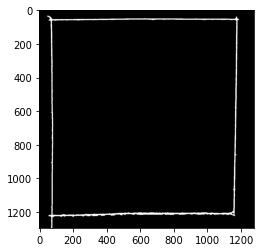

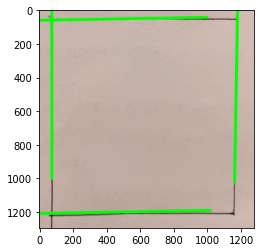

In [13]:
line = Hough_line("vh1.jpg")

In [14]:
line

[[[1032, -1871], [-966, -1906]],
 [[1164, 1020], [1199, -979]],
 [[76, 1000], [76, -1000]],
 [[-998, 78], [1000, 43]],
 [[-978, 1225], [1020, 1190]]]

In [15]:
angle_cal(line)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


-89.99949806299294

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8a44a380-3932-4441-acdf-31a0d8f692bc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>